In [33]:
#PREDICT FUEL EFFICIENCY
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [34]:
#IMPORT LIBRARIES 
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import sqrt 

In [35]:
#IMPORT TENSORFLOW AND KERAS
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

2.6.0


In [36]:
#GET THE DATA
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [37]:
#IMPORT THE DATASET USING PANDAS
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [38]:
#CLEAN THE DATA
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [39]:
#To keep this initial tutorial simple drop those rows.
dataset = dataset.dropna()

In [40]:
#The "Origin" column is really categorical, not numeric. So convert that to a one-hot:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [41]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [42]:
#SPLIT DATASET INTO TRAINNG AND TESTING
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

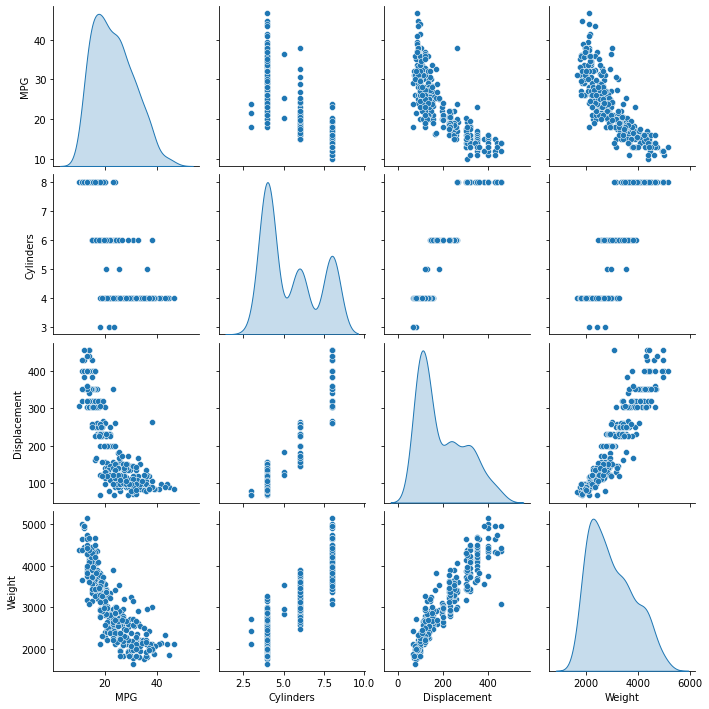

In [43]:
#INSPECT THE DATA
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [44]:
#OVERALL STATISTICS
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [45]:
#LABEL THE TRAINING AND TESTING DATASET
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [46]:
#NORMALIZE THE DATA
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [47]:
#BUILD THE MODEL
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [48]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [49]:
#Take a batch of 10 examples from the training data and call model.predict on it.
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.23479563],
       [-0.02445579],
       [ 0.18269195],
       [ 0.05776851],
       [ 0.10916577],
       [ 0.10961674],
       [ 0.0914076 ],
       [-0.41762   ],
       [-0.10429147],
       [ 0.15382376]], dtype=float32)

In [50]:
#Train the model for 1000 epochs, and record the training and validation accuracy in the history object.
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
 


Epoch: 0, loss:566.4543,  mae:22.4927,  mse:566.4543,  val_loss:554.5034,  val_mae:22.1776,  val_mse:554.5034,  
....................................................................................................
Epoch: 100, loss:6.0335,  mae:1.7053,  mse:6.0335,  val_loss:8.0157,  val_mae:2.1090,  val_mse:8.0157,  
....................................................................................................
Epoch: 200, loss:5.1713,  mae:1.5411,  mse:5.1713,  val_loss:7.9114,  val_mae:2.1751,  val_mse:7.9114,  
....................................................................................................
Epoch: 300, loss:4.5714,  mae:1.4611,  mse:4.5714,  val_loss:7.9549,  val_mae:2.1949,  val_mse:7.9549,  
....................................................................................................
Epoch: 400, loss:4.3869,  mae:1.4009,  mse:4.3869,  val_loss:7.6941,  val_mae:2.1302,  val_mse:7.6941,  
..............................................................

In [51]:
#Visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.560044,1.031558,2.560044,8.835110,2.317969,8.835110,995
996,2.628353,1.086570,2.628353,8.562605,2.225120,8.562605,996
997,2.324390,0.999514,2.324390,8.901024,2.323976,8.901024,997
998,2.579011,1.039406,2.579011,8.812134,2.240001,8.812134,998
999,2.420994,1.029439,2.420994,9.094510,2.372855,9.094510,999


Text(0, 0.5, 'MAE [MPG]')

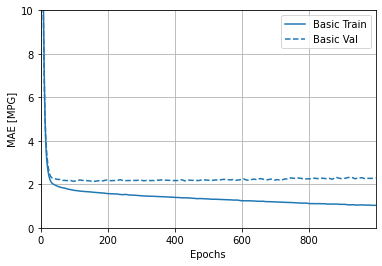

In [52]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')


Text(0, 0.5, 'MSE [MPG^2]')

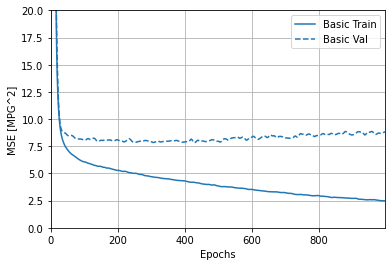

In [53]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [54]:
#use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:574.6575,  mae:22.5797,  mse:574.6575,  val_loss:562.3519,  val_mae:22.2282,  val_mse:562.3519,  
..........................................................................

Text(0, 0.5, 'MAE [MPG]')

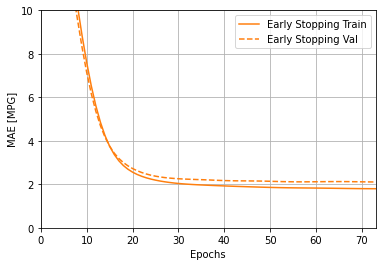

In [55]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [56]:

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.6257 - mae: 1.8592 - mse: 5.6257
Testing set Mean Abs Error:  1.86 MPG


In [61]:
print("Mean square error")
print(mse)
print("Mean absolute error")
print(mae)

rmse = sqrt(mse)
print("Root mean square error")
print(rmse)

Mean square error
5.6257004737854
Mean absolute error
1.85917329788208
Root mean square error
2.371855913369402


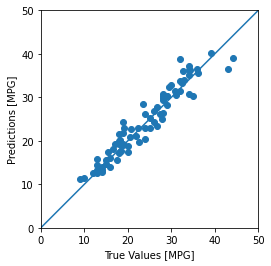

In [58]:
#predict MPG values using data in the testing set:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


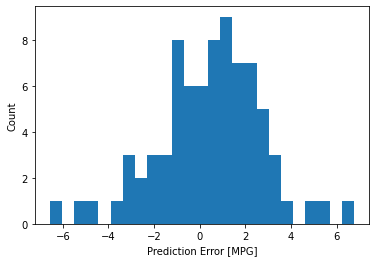

In [59]:
#CALCULATE ERROR
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")